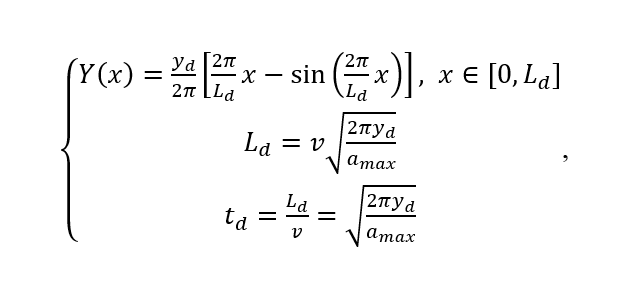

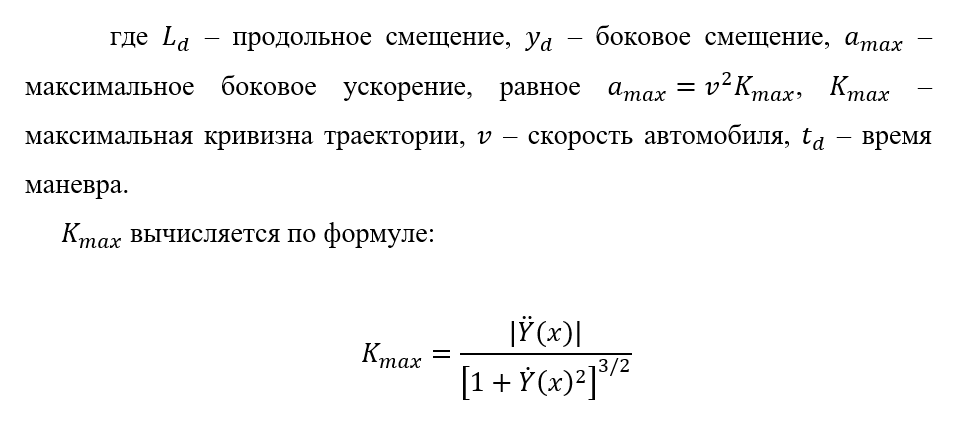

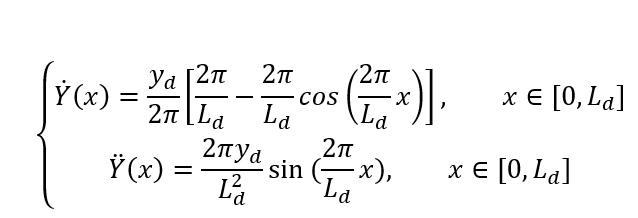

In [1]:
import math
import time
import copy
import scipy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from skimage.draw import line
# from jetracer.nvidia_racecar import NvidiaRacecar

In [2]:
v = 0.5
yd = 0.2
Ld = 4
def path_planer(v, yd=3.75, Ld=30):
    # Ld = v * math.sqrt((2 * math.pi * yd) / a_max)
    x = np.arange(0, Ld, 0.4)
    Y = yd/(2*math.pi) * (2*math.pi*x/Ld - np.sin(2*math.pi*x/Ld))
    # Y1 = (0.5 * yd / math.pi) * (2*math.pi/Ld - (2*math.pi/Ld)*math.cos(2*math.pi*x/Ld))
    # Y2 = (2*math.pi*yd/Ld ** 2) * math.sin(2*math.pi*x/Ld)
    td = Ld / v
    # K_max = abs(Y2)/pow((1 + Y1 ** 2), 3/2)
    # a_max = K_max * v ** 2
    return x, Y, td

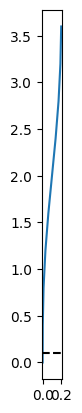

In [49]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
x, Y, t = path_planer(v, yd, Ld)
plt.plot(Y, x)
plt.axhline(yd/2, color='black', linestyle='--')

In [4]:
t

8.0

In [50]:
Y

array([0.        , 0.00129021, 0.00972693, 0.02972693, 0.06129021,
       0.1       , 0.13870979, 0.17027307, 0.19027307, 0.19870979])

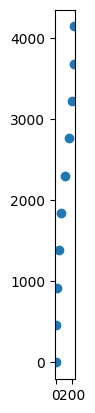

In [38]:
fig, ax = plt.subplots()
ax.set_aspect('equal')
plt.scatter(Y*1150,x*1150)

In [6]:
def angle_to_control(angle_degrees):
    '''convert angle (deg) to control signal ([-1;1])'''
    max_angle_degrees = 65
    control_signal = angle_degrees / max_angle_degrees
    return control_signal

In [41]:
def get_point_angle(x, y):
    '''calculate angle b/w vector (x,y) and horizontal line'''
    angle_rad = np.arctan2(y, x)
    angle_deg = np.degrees(angle_rad)
    return angle_deg


In [45]:
def get_path_angles(x, y):
    '''calculate angles along path'''
    angles = []
    for i in range(1, len(x)):
        angles.append(get_point_angle(x[i] - x[i-1], y[i] - y[i-1]))
    return angles

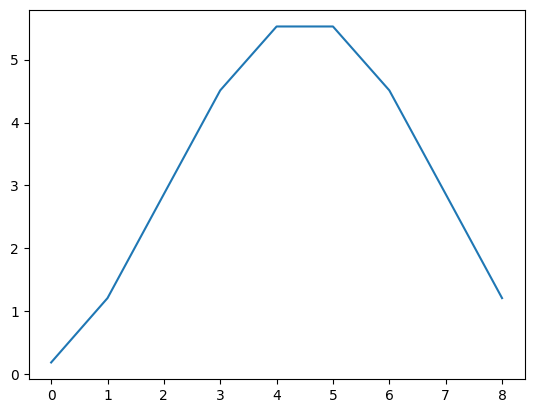

In [46]:
plt.plot(get_path_angles(x, Y))

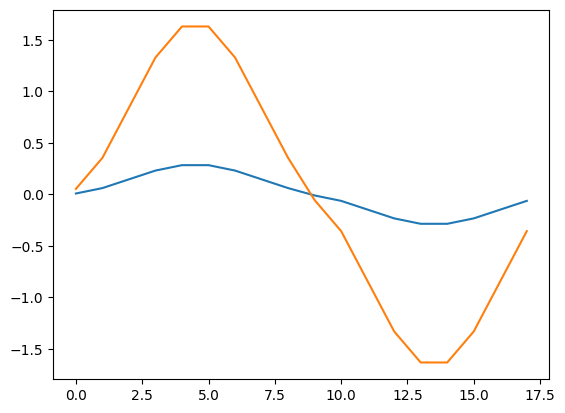

In [30]:
# angular velocity w:
v = 0.5 # linear velocity
L = 0.17 # wheel base
w = np.concatenate((v * np.tan(np.deg2rad(get_path_angles(x, Y))) / L, 
                    v * np.tan(np.deg2rad(-np.array(get_path_angles(x, Y)))) / L))
plt.plot(w)
# steering angle w*dt:
dt = 0.1
plt.plot(np.rad2deg(w*dt))

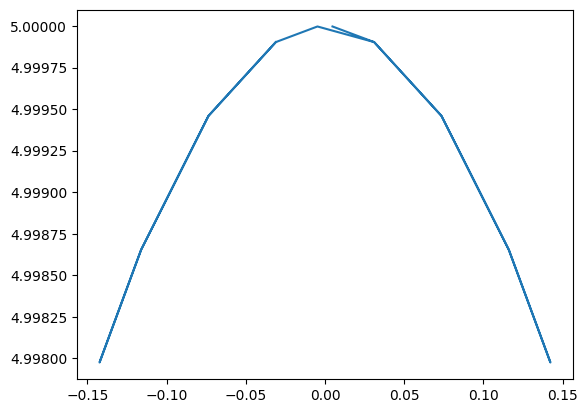

In [34]:
# path x,y:
x = np.cos(w*dt) * v * dt
y = np.sin(w*dt) * v * dt
plt.plot(y*100,x*100)

In [14]:
dt = t/len(x)
dt

0.8

In [11]:
def angle_to_control(angle_degrees):
    '''convert angle (deg) to control signal ([-1;1])'''
    max_angle_degrees = 45
    control_signal = angle_degrees / max_angle_degrees
    return control_signal

In [7]:
def maneuver():
    v = 0.185
    car.throttle = v
    yd = 0.4
    Ld = 2
    X, Y, t = path_planer(0.5, yd, Ld)
    print('x', X)
    print('y', Y)
    print('t', t)
    angles = get_path_angles(X, Y)
    print('angles', angles)
    dt = t / len(X)
    for i in range(len(X)-1):
        # print('angle: ', angles[i])
        steer_control = angle_to_control(angles[i])
        # print('ctrl: ', steer_control)
        car.steering = steer_control
        print(i)
        time.sleep(0.1)
        car.steering = 0.0
        time.sleep(0.1)
    car.steering = 0
    time.sleep(0.1)
    for i in range(len(X)-1):
        # print('angle: ', angles[i])
        steer_control = angle_to_control(angles[i])
        # print('ctrl: ', steer_control)
        car.steering = -steer_control
        print(i)
        time.sleep(0.1)
        car.steering = 0.0
        time.sleep(0.1)
    car.steering = 0
    time.sleep(0.1)
    car.throttle = 0.0
   

In [68]:
def check_obstacle_static(obstacle_map, angles, v, dt):
    '''angles must be in rad'''
    angles = np.deg2rad(angles)
    current_pos = [1000, 2000 // 2]
    l = v * dt * 1150.0 # vector length
    path = copy.copy(obstacle_map)
    for i in range(len(angles)):
        next_pos = [int(current_pos[0] - l * math.cos(angles[i])), int(current_pos[1] + l * math.sin(angles[i]))]
        rr, cc = line(*current_pos, *next_pos)
        current_pos = next_pos
        path[rr, cc] = 255

    return path

In [69]:
obst_map = np.zeros((1001, 2001))
angles = get_path_angles(x, Y)
path = check_obstacle_static(obst_map, angles, v, dt)

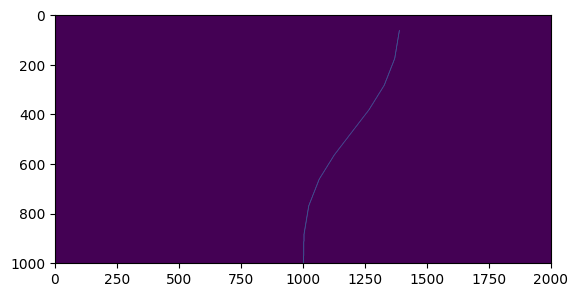

In [70]:
imshow(path)

In [14]:
def get_dist(p1, p2):
    return np.linalg.norm(
        np.array(p1) - np.array(p2)
    )

In [44]:
def check_obstacle_static(obstacle_map, angles, x, y):
    '''angles must be in rad'''
    angles = np.deg2rad(angles)
    current_pos = [obstacle_map.shape[0] - 1, obstacle_map.shape[1] // 2 - 1]
    y = current_pos[1] + y * 1150.0
    x = current_pos[0] - x * 1150.0

    path = copy.copy(obstacle_map)
    for i in range(len(angles)):
        l = get_dist([current_pos[0], current_pos[1]], [x[i], y[i]])
        next_pos = [int(current_pos[0] - l * math.cos(angles[i])), int(current_pos[1] + l * math.sin(angles[i]))]
        rr, cc = line(*current_pos, *next_pos)
        current_pos = next_pos
        path[rr, cc] = 255

    return path

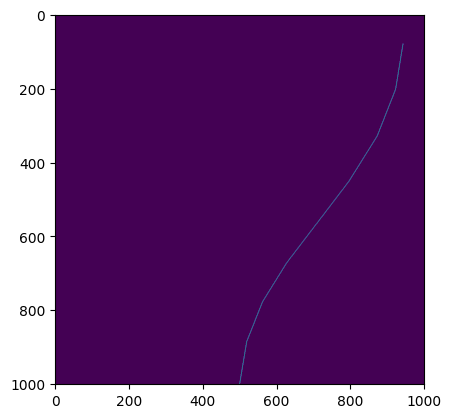

In [45]:
obst_map = np.zeros((1001, 1001))
angles = get_path_angles(x, Y)
x, y, _ = path_planer(v, yd, Ld)
path = check_obstacle_static(obst_map, angles, x, y)
imshow(path)

In [119]:
def maneuver2():
    v = 0.185
    car.throttle = v
    yd = 0.25
    Ld = 4
    X, Y, t = path_planer(0.5, yd, Ld)
    angles = [a*1.5 for a in get_path_angles(X, Y)]
    print('angles', angles)
    dt = t / len(X)
    tmp_angles = []
    for i in range(len(X)-1):
        # print('angle: ', angles[i])
        steer_control = angle_to_control(angles[i])
        # print('ctrl: ', steer_control)
        car.steering = steer_control
        tmp_angles.append(steer_control)
        time.sleep(0.15)
    car.steering = 0
    time.sleep(0.1)
    for i in range(len(X)-1):
        # print('angle: ', angles[i])
        steer_control = angle_to_control(angles[i])
        # print('ctrl: ', steer_control)
        car.steering = -steer_control-0.17
        tmp_angles.append(-steer_control)
        time.sleep(0.15)
    
    time.sleep(0.3)
    # car.steering = 0
    time.sleep(0.5)
    car.throttle = 0.0
    # plt.plot(tmp_angles)

In [129]:
car.steering = 0.0

In [9]:
car = NvidiaRacecar()

In [125]:
maneuver2()

angles [0.346516100960335, 2.2653576367559847, 5.364501562496026, 8.449744686362166, 10.346169992160036, 10.346169992160025, 8.449744686362166, 5.364501562496033, 2.2653576367559856]


In [128]:
car.throttle = 0

In [50]:
car.throttle = 0.0

In [62]:
import torch # Cuda compilation tools, release 10.2, V10.2.89
# Package: nvidia-jetpack Version: 4.5.1-b17 
print(torch.cuda.is_available())

ValueError: libcublas.so.*[0-9] not found in the system path ['/home/jetson/jetracer/diplom/YOLOP/lib/utils', '/usr/lib/python38.zip', '/usr/lib/python3.8', '/usr/lib/python3.8/lib-dynload', '', '/home/jetson/.local/lib/python3.8/site-packages', '/usr/local/lib/python3.8/dist-packages', '/usr/local/lib/python3.8/dist-packages/jetracer-0.0.0-py3.8.egg', '/usr/local/lib/python3.8/dist-packages/adafruit_circuitpython_servokit-1.3.17-py3.8.egg', '/usr/local/lib/python3.8/dist-packages/adafruit_circuitpython_register-1.9.18-py3.8.egg', '/usr/local/lib/python3.8/dist-packages/adafruit_circuitpython_pca9685-3.4.14-py3.8.egg', '/usr/local/lib/python3.8/dist-packages/adafruit_circuitpython_motor-3.4.13-py3.8.egg', '/usr/local/lib/python3.8/dist-packages/adafruit_circuitpython_busdevice-5.2.6-py3.8.egg', '/usr/local/lib/python3.8/dist-packages/Adafruit_Blinka-8.35.0-py3.8.egg', '/usr/local/lib/python3.8/dist-packages/typing_extensions-4.10.0-py3.8.egg', '/usr/local/lib/python3.8/dist-packages/adafruit_circuitpython_typing-1.10.3-py3.8.egg', '/usr/local/lib/python3.8/dist-packages/pyftdi-0.55.0-py3.8.egg', '/usr/local/lib/python3.8/dist-packages/Adafruit_PureIO-1.1.11-py3.8.egg', '/usr/local/lib/python3.8/dist-packages/Adafruit_PlatformDetect-3.62.0-py3.8.egg', '/usr/local/lib/python3.8/dist-packages/adafruit_circuitpython_requests-3.2.0-py3.8.egg', '/usr/local/lib/python3.8/dist-packages/pyusb-1.2.1-py3.8.egg', '/usr/local/lib/python3.8/dist-packages/adafruit_circuitpython_connectionmanager-1.0.1-py3.8.egg', '/usr/local/lib/python3.8/dist-packages/jetcam-0.0.0-py3.8.egg', '/usr/lib/python3/dist-packages', '/usr/lib/python3.8/dist-packages']